In [1]:
import os
import sys

module_path = os.path.abspath(os.path.join('../../src'))
print("adding following folder to path: ",module_path)
if module_path not in sys.path:
    sys.path.append(module_path)

adding following folder to path:  /home/enis/projects/nna/src


In [2]:
import numpy as np 
from numpy import linspace
import pandas as pd


import datetime
from scipy import stats
import time
import copy
from sklearn.preprocessing import minmax_scale
from sklearn.metrics import precision_recall_fscore_support


import csv 
from pathlib import Path
from os import listdir
import pickle

from tabulate import tabulate


from datetime import datetime,timedelta

import itertools


import matplotlib.pyplot as plt
from matplotlib.colors import LinearSegmentedColormap, ListedColormap
import matplotlib.ticker as ticker
import matplotlib.pyplot as plt 
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import ListedColormap
from matplotlib import cm

from pytz import timezone




In [3]:
from pre_process_func import read_queue
from fileUtils import read_file_properties
from labeling_utils import load_labels
from visUtils import get_cycle,createTimeIndex,file2TableDict,reverseTableDict

In [4]:
# INPUT_DIR_PARENT = "/home/data/nna/stinchcomb/NUI_DATA/"


In [5]:
dataFlder="/home/enis/projects/nna/data/"
resultsFlder="/home/enis/projects/nna/results/"


In [6]:
id2name={}

tag_set=["Songbird","Water Bird","Insect","Running Water","Rain","Cable","Wind","Aircraft"]



In [7]:
# file_properties_df=pd.read_pickle("../../data/stinchcomb_dataV1.pkl")
file_properties_df=pd.read_pickle("../../data/realdata_v2No_stinchcomb.pkl")

#important to keep them in order
file_properties_df.sort_values(by=['timestamp'],inplace=True)

# delete older than 2016
fromtime=datetime(2016, 1, 1, 0)
file_properties_df=file_properties_df[file_properties_df.timestamp>=fromtime]


In [8]:
# PARAMS
# FREQS to reduce results 
freq="2H"


# possible places to pick
# sorted(pd.unique(file_properties_df.site_id.values))
# areas to be visualized


selected_areas=["15",]#"21","22","27","31","35","37","48",]


In [9]:

globalindex,all_start,all_end=createTimeIndex(selected_areas,file_properties_df,freq)

selected_tag_name="_SONGBIRD"
model_tag_names=["CABLE","RUNNINGWATER","INSECT", "RAIN", "WATERBIRD", "WIND", "SONGBIRD", "AIRCRAFT"]

model_tag_names=["_"+i for i in model_tag_names]
selected_tag_name=model_tag_names[:]

weather_cols=[]
globalcolumns=model_tag_names#selected_areas+weather_cols


In [10]:
print(" Duration of selected data period:",(all_end-all_start).days,"days")
print(" Starts: {} \n Ends:   {}".format(all_end,all_start))

 Duration of selected data period: 39 days
 Starts: 2019-06-14 23:59:59 
 Ends:   2019-05-06 00:00:00


In [ ]:
result_path="/scratch/enis/data/nna/real/"


df_dict,no_result_paths = file2TableDict(selected_areas,model_tag_names,globalindex,
                                         globalcolumns,file_properties_df,freq,dataFreq="10S",
                                         result_path=result_path,prob2binaryFlag=False)


print("{} number of files do not have results".format(len(no_result_paths)))

df_dict_reverse=reverseTableDict(selected_areas,df_dict,model_tag_names)


In [ ]:
df_dict_reverse

In [39]:
df_count,df_sums=df_dict_reverse[selected_tag_name]

In [43]:
df_count.sum()

15    116582.0
21    121136.0
22    122735.0
27     85544.0
31    148880.0
35    113397.0
37    107141.0
48    130384.0
dtype: float64

In [45]:
df_freq=df_sums/df_count
# del df_freq['UMIAT']

df_freq=df_freq*100
df_freq=df_freq.dropna(how='all')
# df_freq=pd.concat([df_freq, normal_weather], axis=1, join='inner')

In [46]:
df_freq.sum()

15    17233.961130
21     9472.567544
22    14595.118477
27     5864.958766
31    19175.931175
35    12602.543502
37    12076.172513
48    13604.462938
dtype: float64

In [53]:

# cord_list=sorted(list(cord.items()),key=lambda x: x[1][0],reverse=True)

# cord_list=list(filter(lambda x: x[0] in df_freq.columns ,cord_list))

cord_list=[(i,(0,0)) for i in df_freq.columns]

In [54]:
months=[df_freq.loc['2019-05':'2019-05'],df_freq.loc['2019-06':'2019-06']]
# months2=[df_freq.loc['2016-06-01':'2016-06-30'],df_freq.loc['2016-07-01':'2016-07-31'],df_freq.loc['2016-08-01':'2016-08-31']]

# make them all same month for aligning 
for i,month in enumerate(months):
    months[i]=month.rename(index=lambda x: x.replace(month=7))
    


In [323]:
# for i,month in enumerate(months):
#     print(month)

In [55]:
linestyle_str = [
     ('solid', 'solid'),      # Same as (0, ()) or '-'
     ('dotted', 'dotted'),    # Same as (0, (1, 1)) or '.'
     ('dashed', 'dashed'),    # Same as '--'
     ('dashdot', 'dashdot'),  # Same as '-.
     ('densely dotted',        (0, (1, 1))),
     ('densely dashed',        (0, (5, 1))),
    ('densely dashdotted',    (0, (3, 1, 1, 1))),
     ('densely dashdotdotted', (0, (3, 1, 1, 1, 1, 1)))]


In [56]:
cord_list,weather_cols

([('15', (0, 0)),
  ('21', (0, 0)),
  ('22', (0, 0)),
  ('27', (0, 0)),
  ('31', (0, 0)),
  ('35', (0, 0)),
  ('37', (0, 0)),
  ('48', (0, 0))],
 [])

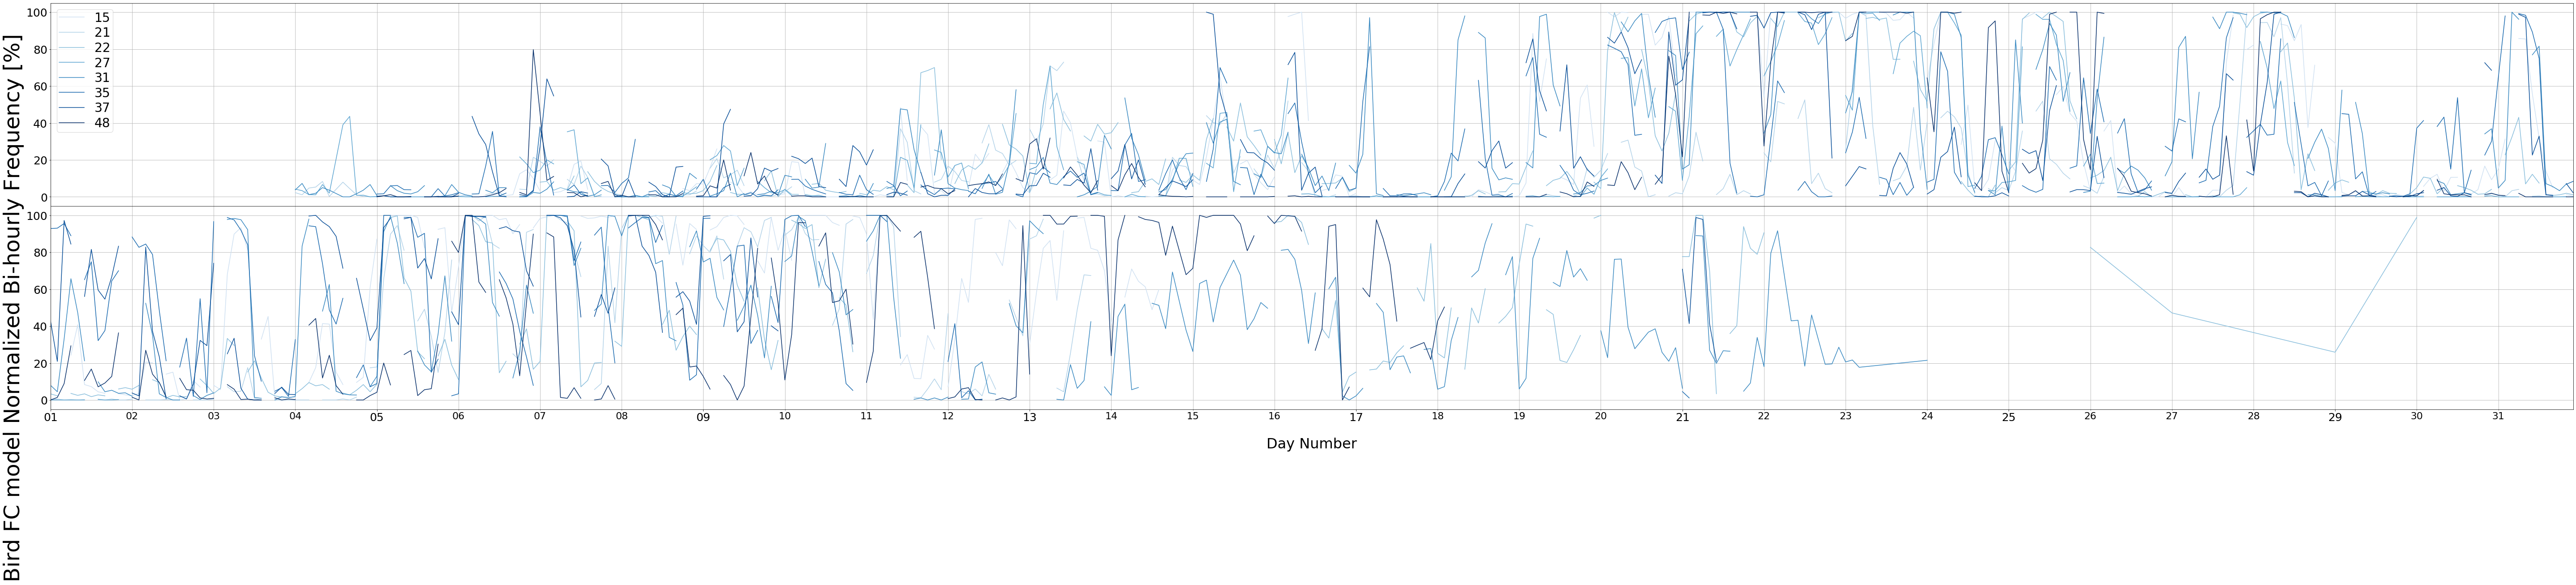

In [61]:

plt.rcParams["axes.prop_cycle"] = get_cycle("Blues",N=8)


fig, ax = plt.subplots(figsize=(80,18),nrows=len(months),sharex=True, sharey=True,gridspec_kw={'hspace': 0})

markers = itertools.cycle((',', '+', '.', 'o', '*')) 

weather_colors=["firebrick","darkorange","green","seagreen","lightpink"]

for monthi,month in enumerate(months):
    # for col in df_freq.columns:
    for i,(col,(lat,long)) in enumerate(cord_list):
        if col in weather_cols:
            index=weather_cols.index(col)
            ax[monthi].plot_date(month.index.to_pydatetime(), month[col],linestyle="-",marker=" ",color=weather_colors[index])
        else:
            ax[monthi].plot_date(month.index.to_pydatetime(), month[col],linestyle="-",marker=" ")
        

ax[0].legend( labels=[id2name.get(x[0],x[0]) for x in cord_list],loc='upper left', 
            borderpad=0.2, labelspacing=0.2, fontsize=28, 
            frameon=True) # frameon=False to remove frame.


ax[1].set_ylabel('{} Normalized Bi-hourly Frequency [%]'.format(selected_tag_name),fontsize=48) #, fontweight='black')

ax[-1].set_xlabel('Day Number', fontsize=32)


for an_ax in ax:
    
    locator=dates.DayLocator()
    an_ax.xaxis.set_minor_locator(locator)

    an_ax.xaxis.set_minor_formatter(dates.DateFormatter('%d\n'))

    an_ax.xaxis.grid(True, which="minor")
    an_ax.xaxis.grid(True, which="major")


    an_ax.xaxis.set_major_locator(dates.AutoDateLocator())
    an_ax.xaxis.set_major_formatter(dates.DateFormatter('%d\n'))

    an_ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:.0f}'))
    an_ax.yaxis.grid()
    an_ax.tick_params(labelsize=22,which="minor")
    an_ax.tick_params(labelsize=25,which="major")
    
plt.tight_layout()
plt.margins(x=0)


plt.show()

fig.savefig("all_"+selected_tag_name+"_weather_"+freq +'.png')


